In [1]:
import torch
from torch.utils.data import Dataset, DataLoader
import os
import glob 
import matplotlib.image as img
import matplotlib.pyplot as plt
import torchvision
import torch.nn as nn
import numpy as np
import math
import csv
from PIL import Image
import time


In [2]:
# set device 

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print("device type:", device)
print("current device:", torch.cuda.get_device_name(torch.cuda.current_device()))

dtype = torch.float

device type: cuda
current device: NVIDIA GeForce GTX 1060 6GB


In [3]:
# map labels to ids (alphabetically)

classIdByLabel = {}
classes = set([path.split("/")[3] for path in glob.glob("../dane/test/*", recursive=False)])
i = 0
for className in sorted(classes):
    classIdByLabel[className] = i
    i += 1

print("classIdByLabel:", classIdByLabel)

classIdByLabel: {'ABBOTTS BABBLER': 0, 'ABBOTTS BOOBY': 1, 'ABYSSINIAN GROUND HORNBILL': 2, 'AFRICAN CROWNED CRANE': 3, 'AFRICAN EMERALD CUCKOO': 4, 'AFRICAN FIREFINCH': 5, 'AFRICAN OYSTER CATCHER': 6, 'AFRICAN PIED HORNBILL': 7, 'AFRICAN PYGMY GOOSE': 8, 'ALBATROSS': 9, 'ALBERTS TOWHEE': 10, 'ALEXANDRINE PARAKEET': 11, 'ALPINE CHOUGH': 12, 'ALTAMIRA YELLOWTHROAT': 13, 'AMERICAN AVOCET': 14, 'AMERICAN BITTERN': 15, 'AMERICAN COOT': 16, 'AMERICAN DIPPER': 17, 'AMERICAN FLAMINGO': 18, 'AMERICAN GOLDFINCH': 19, 'AMERICAN KESTREL': 20, 'AMERICAN PIPIT': 21, 'AMERICAN REDSTART': 22, 'AMERICAN ROBIN': 23, 'AMERICAN WIGEON': 24, 'AMETHYST WOODSTAR': 25, 'ANDEAN GOOSE': 26, 'ANDEAN LAPWING': 27, 'ANDEAN SISKIN': 28, 'ANHINGA': 29, 'ANIANIAU': 30, 'ANNAS HUMMINGBIRD': 31, 'ANTBIRD': 32, 'ANTILLEAN EUPHONIA': 33, 'APAPANE': 34, 'APOSTLEBIRD': 35, 'ARARIPE MANAKIN': 36, 'ASHY STORM PETREL': 37, 'ASHY THRUSHBIRD': 38, 'ASIAN CRESTED IBIS': 39, 'ASIAN DOLLARD BIRD': 40, 'ASIAN GREEN BEE EATER': 41,

In [4]:
# create dataset class

class BirdDataset(Dataset):
    def __init__(self, dataset_type: str, transform=None):
        self.dataset_directory = "../dane/" + dataset_type +"/"
        self.transform = transform
        self.image_paths = glob.glob(self.dataset_directory + "**/*.jpg", recursive=True)
        self.labels = torch.tensor([classIdByLabel[path.split("/")[3]] for path in self.image_paths])

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, i):

        image = Image.open(self.image_paths[i])
        # image = img.imread(self.image_paths[i])

        if self.transform:
            image = self.transform(image)
        
        return image, self.labels[i]


In [5]:
# example data for testing if everything works

transform = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor()
    ])
example_batch_size = 32
exampleTrainDataset = BirdDataset("train", transform)

print(len(exampleTrainDataset))
classes = set([path.split("/")[3] for path in exampleTrainDataset.image_paths])
classesCount = len(classes)
print(classesCount)
print("\n".join([(str(classIdByLabel[c]) + " " + c) for c in sorted(classes)]))

exampleTrainLoader = DataLoader(exampleTrainDataset, batch_size=example_batch_size, shuffle=True, num_workers=4, drop_last=True)

63135
525
0 ABBOTTS BABBLER
1 ABBOTTS BOOBY
2 ABYSSINIAN GROUND HORNBILL
3 AFRICAN CROWNED CRANE
4 AFRICAN EMERALD CUCKOO
5 AFRICAN FIREFINCH
6 AFRICAN OYSTER CATCHER
7 AFRICAN PIED HORNBILL
8 AFRICAN PYGMY GOOSE
9 ALBATROSS
10 ALBERTS TOWHEE
11 ALEXANDRINE PARAKEET
12 ALPINE CHOUGH
13 ALTAMIRA YELLOWTHROAT
14 AMERICAN AVOCET
15 AMERICAN BITTERN
16 AMERICAN COOT
17 AMERICAN DIPPER
18 AMERICAN FLAMINGO
19 AMERICAN GOLDFINCH
20 AMERICAN KESTREL
21 AMERICAN PIPIT
22 AMERICAN REDSTART
23 AMERICAN ROBIN
24 AMERICAN WIGEON
25 AMETHYST WOODSTAR
26 ANDEAN GOOSE
27 ANDEAN LAPWING
28 ANDEAN SISKIN
29 ANHINGA
30 ANIANIAU
31 ANNAS HUMMINGBIRD
32 ANTBIRD
33 ANTILLEAN EUPHONIA
34 APAPANE
35 APOSTLEBIRD
36 ARARIPE MANAKIN
37 ASHY STORM PETREL
38 ASHY THRUSHBIRD
39 ASIAN CRESTED IBIS
40 ASIAN DOLLARD BIRD
41 ASIAN GREEN BEE EATER
42 ASIAN OPENBILL STORK
43 AUCKLAND SHAQ
44 AUSTRAL CANASTERO
45 AUSTRALASIAN FIGBIRD
46 AVADAVAT
47 AZARAS SPINETAIL
48 AZURE BREASTED PITTA
49 AZURE JAY
50 AZURE TANAGER
51

0 torch.Size([32, 3, 224, 224]) 32
1 torch.Size([32, 3, 224, 224]) 32
2 torch.Size([32, 3, 224, 224]) 32
3 torch.Size([32, 3, 224, 224]) 32


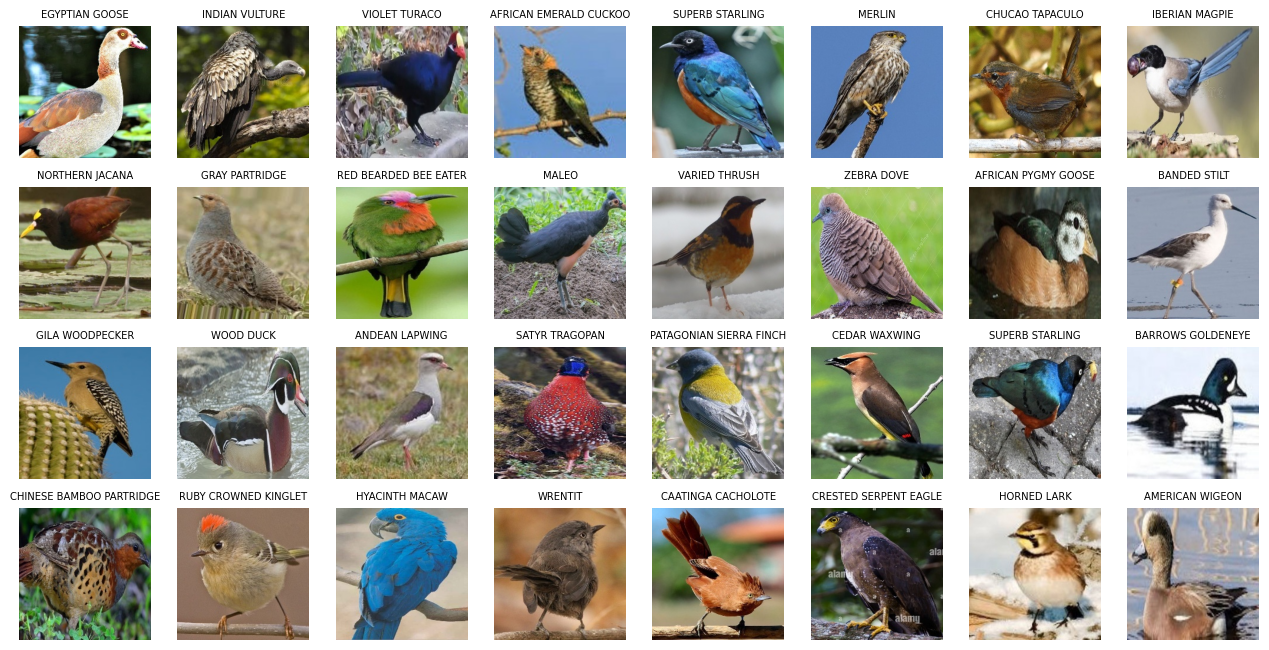

In [6]:
# show single batch of example data

for i_batch, sample_batch in enumerate(exampleTrainLoader):
    images_batch, labels_batch = sample_batch
    print(i_batch, images_batch.size(), len(labels_batch))

    # observe 4th batch and stop.
    if i_batch == 3:
        plt.figure(figsize=(16,8))
        plt.rc('font', size=6)

        for index in range(example_batch_size):
            plt.subplot(4,8,index+1)
            plt.imshow(images_batch[index].squeeze().permute(1,2,0))
            plt.title(list(classIdByLabel.keys())[list(classIdByLabel.values()).index(labels_batch[index])])
            plt.axis('off')

        
        plt.ioff()
        plt.show()
        break

In [7]:
# tune a pretrained model

weights = torchvision.models.EfficientNet_B0_Weights.IMAGENET1K_V1
model = torchvision.models.efficientnet_b0(weights=weights)
preprocess = weights.transforms()
in_features = model.classifier[1].in_features

dropout = 0.2
model.classifier = nn.Sequential(
    # nn.Linear(1280, 1000),
    # nn.ReLU(),
    # nn.Dropout(dropout),
    # nn.Linear(1000, 700),
    # nn.ReLU(),
    # nn.Dropout(dropout),
    # nn.Linear(700, 525),
    # nn.Softmax(dim=-1)

    # nn.Linear(in_features, in_features//2),
    # nn.Dropout(dropout),
    # nn.Linear(in_features//2, in_features//4),
    nn.Dropout(dropout),
    nn.Linear(in_features, classesCount)
)

for name, param in model.named_parameters():
    if name.split(".")[0] == "classifier":
        param.requires_grad = True
    else: 
        param.requires_grad = False

print(model)

EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActivat

In [ ]:
# create datasets 

batch_size = 32

trainDataset = BirdDataset("train", preprocess)
trainLoader = DataLoader(trainDataset, batch_size=batch_size, shuffle=True, num_workers=4, drop_last=True)

# validDataset = BirdDataset("valid", preprocess)
# validLoader = DataLoader(validDataset, batch_size=batch_size, shuffle=True, num_workers=4, drop_last=True)

# testDataset = BirdDataset("test", preprocess)
# testLoader = DataLoader(testDataset, batch_size=batch_size, shuffle=False, num_workers=4, drop_last=True)

In [59]:
# train

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=1e-3, momentum=0.9) # , weight_decay=1e-5
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)
step = 500
best_acc = 0.0
epochs = 5

if torch.cuda.device_count() > 1:
    model = nn.DataParallel(model)
model.to(device)
model.train()

for epoch in range(epochs):

    correct = 0
    running_loss = 0.0
    timestart = time.time()
    epochtime = time.time()

    for i, data in enumerate(trainLoader, 0):        
        # get the inputs
        images, labels = data
        images = images.to(device)
        labels = labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)

        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item() * images.size(0)
        correct += torch.sum(predicted == labels.data)
        
        if i % step == step-1:
            print(f'[epoch: {epoch + 1}, {100*batch_size*(i + 1)/len(trainDataset):.3f}%, {math.floor(time.time() - timestart):3d}s] loss: {running_loss / len(trainDataset):.3f}')
            timestart = time.time()
            
    scheduler.step()
    
    epoch_loss = running_loss / len(trainDataset)
    accuracy = correct.double() / len(trainDataset)
    print(f'epoch: {epoch + 1}/{epochs}, time: {math.floor(time.time() - epochtime)}s, accuracy: {accuracy:.3f}, loss: {epoch_loss:.3f} ----------------------------------------')


print('done')

[epoch: 1, 25.343%,  43s] loss: 1.470
[epoch: 1, 50.685%,  43s] loss: 2.896
[epoch: 1, 76.028%,  43s] loss: 4.277
epoch: 1/5, time: 172s, accuracy: 0.242, loss: 5.543 ----------------------------------------
[epoch: 2, 25.343%,  43s] loss: 1.294
[epoch: 2, 50.685%,  43s] loss: 2.547
[epoch: 2, 76.028%,  43s] loss: 3.759
epoch: 2/5, time: 172s, accuracy: 0.439, loss: 4.870 ----------------------------------------
[epoch: 3, 25.343%,  43s] loss: 1.134
[epoch: 3, 50.685%,  43s] loss: 2.236
[epoch: 3, 76.028%,  43s] loss: 3.305
epoch: 3/5, time: 172s, accuracy: 0.539, loss: 4.278 ----------------------------------------
[epoch: 4, 25.343%,  43s] loss: 0.999
[epoch: 4, 50.685%,  43s] loss: 1.969
[epoch: 4, 76.028%,  43s] loss: 2.912
epoch: 4/5, time: 172s, accuracy: 0.605, loss: 3.773 ----------------------------------------
[epoch: 5, 25.343%,  43s] loss: 0.880
[epoch: 5, 50.685%,  43s] loss: 1.739
[epoch: 5, 76.028%,  43s] loss: 2.573
epoch: 5/5, time: 173s, accuracy: 0.648, loss: 3.345 -